## Import Dataset

In [1]:
!pip install gdown

In [2]:
!gdown --folder https://drive.google.com/drive/folders/1dydbU9HlSIgGQBzYMLogDNI27uO6wga7?usp=drive_link

Retrieving folder contents
Retrieving folder 18jHYsTY6jycKhOJD94MW3SXjoDiwjnCc Data_อาคารจามจุรี 9
Processing file 1Vaiou5E3ZVrIEa5etL4p0fMMAfknhnGL รายงานสรุป-Demand-รายวัน-อาคารจามจุรี9-06-2024.xlsx
Processing file 10s5mmIUpazVKxJYM3-eO0YEYgii3sGIx รายงานสรุป-Demand-รายวัน-อาคารจามจุรี9-07-2024.xlsx
Processing file 1JHVpDqwYYiDCn8tA-ldoXOrRfVQNg4lA รายงานสรุป-Demand-รายวัน-อาคารจามจุรี9-08-2024.xlsx
Processing file 1yNwJgHxR_HO6eyb8NUB0kMsw8DPOCcI4 รายงานสรุป-Demand-รายวัน-อาคารจามจุรี9-09-2024.xlsx
Processing file 1TpoAyqP1zGbb9cxi2hsoZTiFKX3MkxLP รายงานสรุป-Demand-รายวัน-อาคารจามจุรี9-02-2024.xlsx
Processing file 1p5SpyFtAtk-FX_dd0DEPXsopfGJavker รายงานสรุป-Demand-รายวัน-อาคารจามจุรี9-01-2024.xlsx
Processing file 1eKf4oYaMylY90vWTAGTBFotOcp0bA_nZ รายงานสรุป-Demand-รายวัน-อาคารจามจุรี9-04-2024.xlsx
Processing file 12CVOQWTfgBJ7CMimiPsI8-H-VbKrF9fg รายงานสรุป-Demand-รายวัน-อาคารจามจุรี9-03-2024.xlsx
Processing file 15uy45zg_JacL8lcfYPWSqtZ3jtOb8lgu รายงานสรุป-Demand-รายวัน-อาคารจามจุ

## Load & Clean the Data

In [5]:
import os
import re
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

# --------- CONFIGURATION ---------
ROOT_XLSX_DIR = "Load-data"
CLEANED_CSV_DIR = "cleaned_data"
PREPROCESSED_CSV_DIR = "preprocessed_data"
FINAL_WIDE_CSV = "all_data_df.csv"
FINAL_LONG_CSV = "all_data_timeseries.csv"
# ---------------------------------

def clean_header_and_drop_unused_rows(tmp_df):
    tmp_df.columns = tmp_df.iloc[0]
    tmp_df = tmp_df[1:].reset_index(drop=True)
    if 'Date' in tmp_df.columns:
        tmp_df = tmp_df[~pd.isna(tmp_df['Date'])]
    return tmp_df

def process_excel_file(file_info):
    file_path, rel_path = file_info
    try:
        tmp_df = pd.read_excel(file_path)
        cleaned_df = clean_header_and_drop_unused_rows(tmp_df)
        output_path = os.path.join(CLEANED_CSV_DIR, rel_path).replace(".xlsx", ".csv")
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cleaned_df.to_csv(output_path, index=False)
        return f"✅ Excel Processed: {file_path}"
    except Exception as e:
        return f"❌ Excel Error in {file_path}: {str(e)}"

def preprocess_and_add_datetime(tmp_df, filename):
    match = re.search(r"(\d{2})-(\d{4})", filename)
    if not match:
        raise ValueError(f"❌ Cannot extract date from filename: {filename}")

    start_month = int(match.group(1))
    start_year = int(match.group(2))
    tmp_df = tmp_df.reset_index(drop=True)

    date_range = pd.date_range(start=datetime(start_year, start_month, 1), periods=len(tmp_df), freq='D')
    tmp_df['Date'] = date_range

    time_cols = [col for col in tmp_df.columns if col != 'Date']
    tmp_df[time_cols] = tmp_df[time_cols].apply(pd.to_numeric, errors='coerce')
    return tmp_df

def process_csv_file(file_info):
    file_path, rel_path = file_info
    try:
        tmp_df = pd.read_csv(file_path)
        processed_df = preprocess_and_add_datetime(tmp_df, os.path.basename(file_path))

        station_name = os.path.normpath(rel_path).split(os.sep)[0]
        processed_df.insert(0, 'station_name', station_name)

        output_path = os.path.join(PREPROCESSED_CSV_DIR, rel_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        processed_df.to_csv(output_path, index=False)
        return f"✅ CSV Processed: {file_path}"
    except Exception as e:
        return f"❌ CSV Error in {file_path}: {str(e)}"

def gather_files(root_dir, extension):
    files = []
    for subdir, _, filenames in os.walk(root_dir):
        for f in filenames:
            if f.endswith(extension):
                full = os.path.join(subdir, f)
                rel = os.path.relpath(full, root_dir)
                files.append((full, rel))
    return files

def concatenate_preprocessed_data(output_dir):
    all_data = []
    for subdir, _, files in os.walk(output_dir):
        for file in files:
            if file.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(subdir, file))
                    all_data.append(df)
                except Exception as e:
                    print(f"❌ Failed to read {file}: {e}")
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

def convert_to_timeseries_long_format(df):
    time_columns = [col for col in df.columns if re.match(r"^\d{1,2}:\d{2}$", str(col))]
    long_df = df.melt(id_vars=['station_name', 'Date'], value_vars=time_columns,
                      var_name='Time', value_name='Electricity(kW)')
    long_df['Date'] = pd.to_datetime(long_df['Date'].astype(str) + ' ' + long_df['Time'])
    long_df.drop(columns=['Time'], inplace=True)
    long_df.sort_values(by=['station_name', 'Date'], inplace=True)
    return long_df

# ----------- MAIN EXECUTION FLOW -----------
if __name__ == "__main__":
    # Step 1: Clean Excel files to CSV
    xlsx_files = gather_files(ROOT_XLSX_DIR, ".xlsx")
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap_unordered(process_excel_file, xlsx_files), total=len(xlsx_files)))
    for res in results:
        print(res)

    # Step 2: Preprocess cleaned CSVs
    csv_files = gather_files(CLEANED_CSV_DIR, ".csv")
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap_unordered(process_csv_file, csv_files), total=len(csv_files)))
    for res in results:
        print(res)

    # Step 3: Concatenate all preprocessed CSVs
    all_data_df = concatenate_preprocessed_data(PREPROCESSED_CSV_DIR)
    if not all_data_df.empty:
        all_data_df.to_csv(FINAL_WIDE_CSV, index=False)
        print(f"✅ Wide-format saved to {FINAL_WIDE_CSV}")

        # Step 4: Convert to long time series format
        long_df = convert_to_timeseries_long_format(all_data_df)
        long_df.to_csv(FINAL_LONG_CSV, index=False)
        print(f"✅ Long-format saved to {FINAL_LONG_CSV}")
    else:
        print("⚠️ No data found for concatenation.")

100%|██████████| 71/71 [00:02<00:00, 27.56it/s]

✅ Excel Processed: Load-data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-05-2024.xlsx
✅ Excel Processed: Load-data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-03-2024.xlsx
✅ Excel Processed: Load-data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-11-2024.xlsx
✅ Excel Processed: Load-data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-06-2024.xlsx
✅ Excel Processed: Load-data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-02-2024.xlsx
✅ Excel Processed: Load-data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-09-2024.xlsx
✅ Excel Processed: Load-data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-01-2024.xlsx
✅ Excel Processed: Load-data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-04-2024.xlsx
✅ Excel Processed: Load-data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-08-2024.xlsx
✅ Excel Processed: Load-data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-10-2024.xlsx
✅ Excel Processed: Load-data/Data_สถานีชาร์จ/รายงานสรุป-Dema


100%|██████████| 71/71 [00:01<00:00, 54.87it/s]


✅ CSV Processed: cleaned_data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-02-2024.csv
✅ CSV Processed: cleaned_data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-04-2024.csv
✅ CSV Processed: cleaned_data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-12-2023.csv
✅ CSV Processed: cleaned_data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-01-2024.csv
✅ CSV Processed: cleaned_data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-11-2024.csv
✅ CSV Processed: cleaned_data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-08-2024.csv
✅ CSV Processed: cleaned_data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-06-2024.csv
✅ CSV Processed: cleaned_data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-09-2024.csv
✅ CSV Processed: cleaned_data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-07-2024.csv
✅ CSV Processed: cleaned_data/Data_สถานีชาร์จ/รายงานสรุป-Demand-รายวัน-สถานีชาร์จ-05-2024.csv
✅ CSV Processed: cleaned_data/Data_สถานีชาร์จ/รายงานสรุป-Dem

In [16]:
long_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204192 entries, 89 to 204039
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   station_name     204192 non-null  object        
 1   Date             204192 non-null  datetime64[ns]
 2   Electricity(kW)  204070 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 6.2+ MB


In [20]:
long_df['Electricity(kW)'].max()

817.0

## New Sample

In [ ]:
font_path = "/kaggle/input/font-prompt/Prompt/Prompt-Regular.ttf"

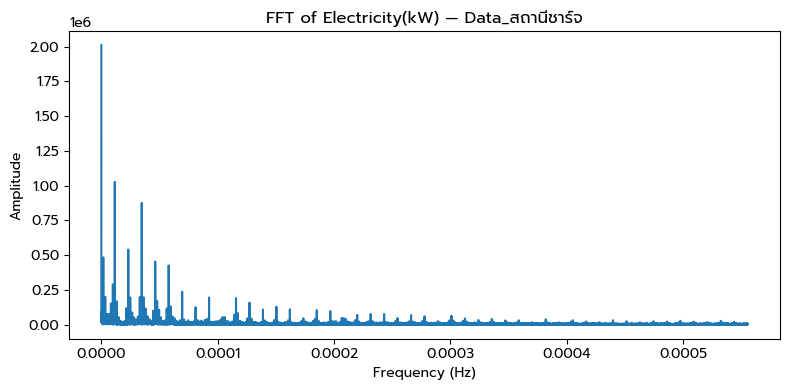

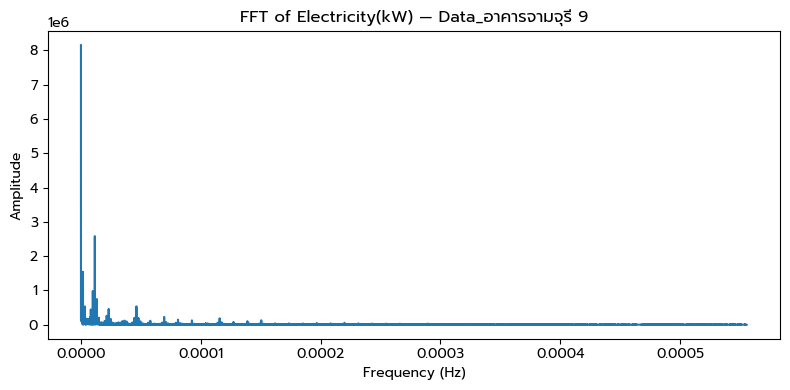

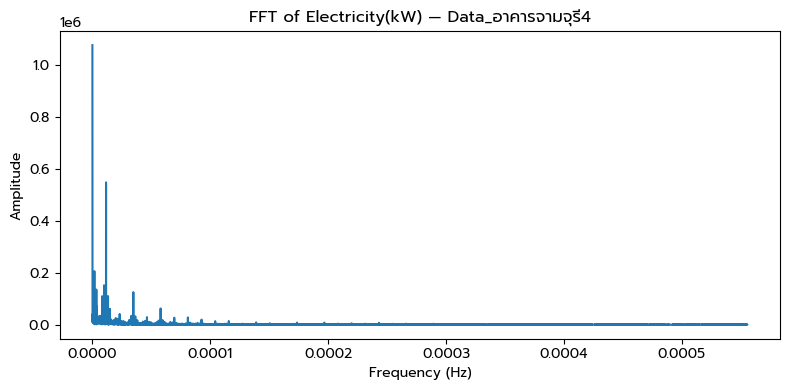

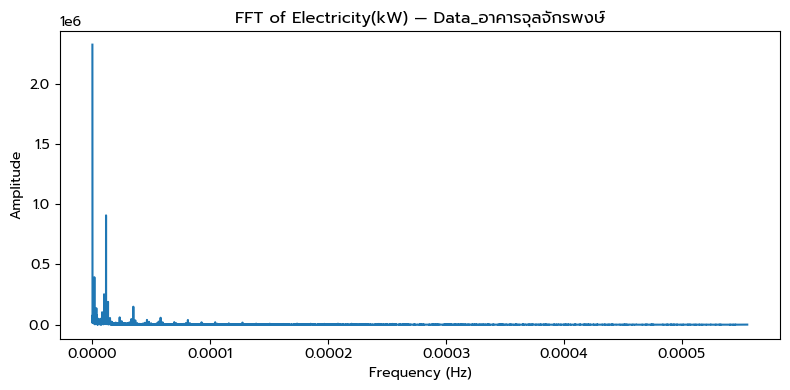

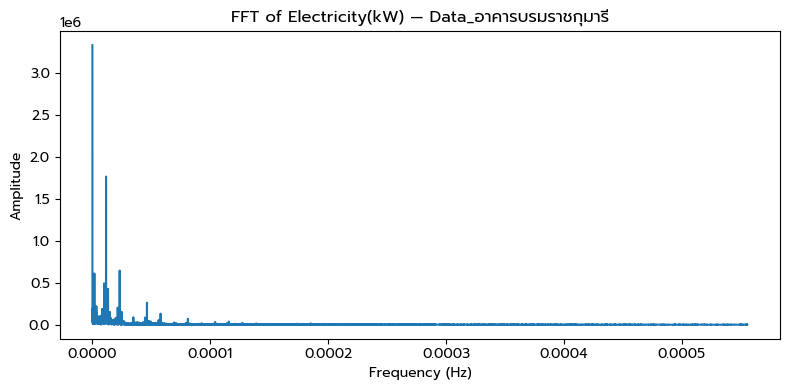

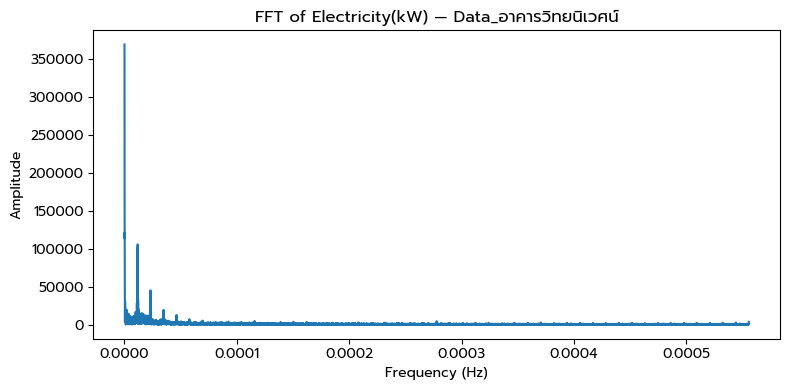

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Path to your font file
font_path = "/kaggle/input/font-prompt/Prompt/Prompt-Regular.ttf"
prop = fm.FontProperties(fname=font_path)

# Option A: set globally for all text
plt.rcParams['font.family'] = prop.get_name()
fm.fontManager.addfont(font_path)

# Ensure your DataFrame is sorted by time
long_df = long_df.sort_values(['station_name', 'Date'])

# Get unique station names
stations = long_df['station_name'].unique()

for station in stations:
    df = long_df[long_df['station_name'] == station]
    y = df['Electricity(kW)'].fillna(0).values
    n = len(y)
    if n < 2:
        continue

    dt = (df['Date'].iloc[1] - df['Date'].iloc[0]).total_seconds()
    yf = np.fft.fft(y)
    xf = np.fft.fftfreq(n, d=dt)
    mask = xf >= 0

    plt.figure(figsize=(8, 4))
    plt.plot(xf[mask], np.abs(yf[mask]))
    
    # Option B: set per‐text (if you didn’t set rcParams)
    # plt.title(f"FFT of Electricity(kW) — {station}", fontproperties=prop)
    # plt.xlabel("Frequency (Hz)", fontproperties=prop)
    # plt.ylabel("Amplitude", fontproperties=prop)

    plt.title(f"FFT of Electricity(kW) — {station}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

## Merge FFT

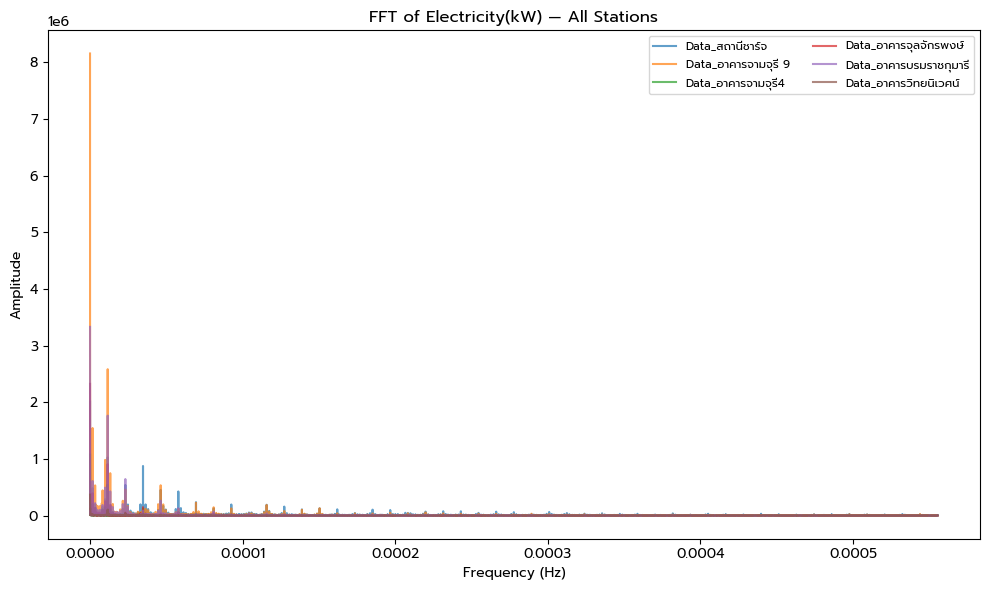

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# — your font setup (if needed) —
font_path = "/kaggle/input/font-prompt/Prompt/Prompt-Regular.ttf"
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()

# sort once up front
long_df = long_df.sort_values(['station_name', 'Date'])
stations = long_df['station_name'].unique()

# create one figure for all stations
plt.figure(figsize=(10, 6))

for station in stations:
    df = long_df[long_df['station_name'] == station]
    y = df['Electricity(kW)'].fillna(0).values
    n = y.shape[0]
    if n < 2:
        continue

    # compute FFT
    dt = (df['Date'].iloc[1] - df['Date'].iloc[0]).total_seconds()
    yf = np.fft.fft(y)
    xf = np.fft.fftfreq(n, d=dt)
    mask = xf >= 0

    # plot on the same axes
    plt.plot(xf[mask], np.abs(yf[mask]), label=station, alpha=0.7)

# finalize
plt.title("FFT of Electricity(kW) — All Stations")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

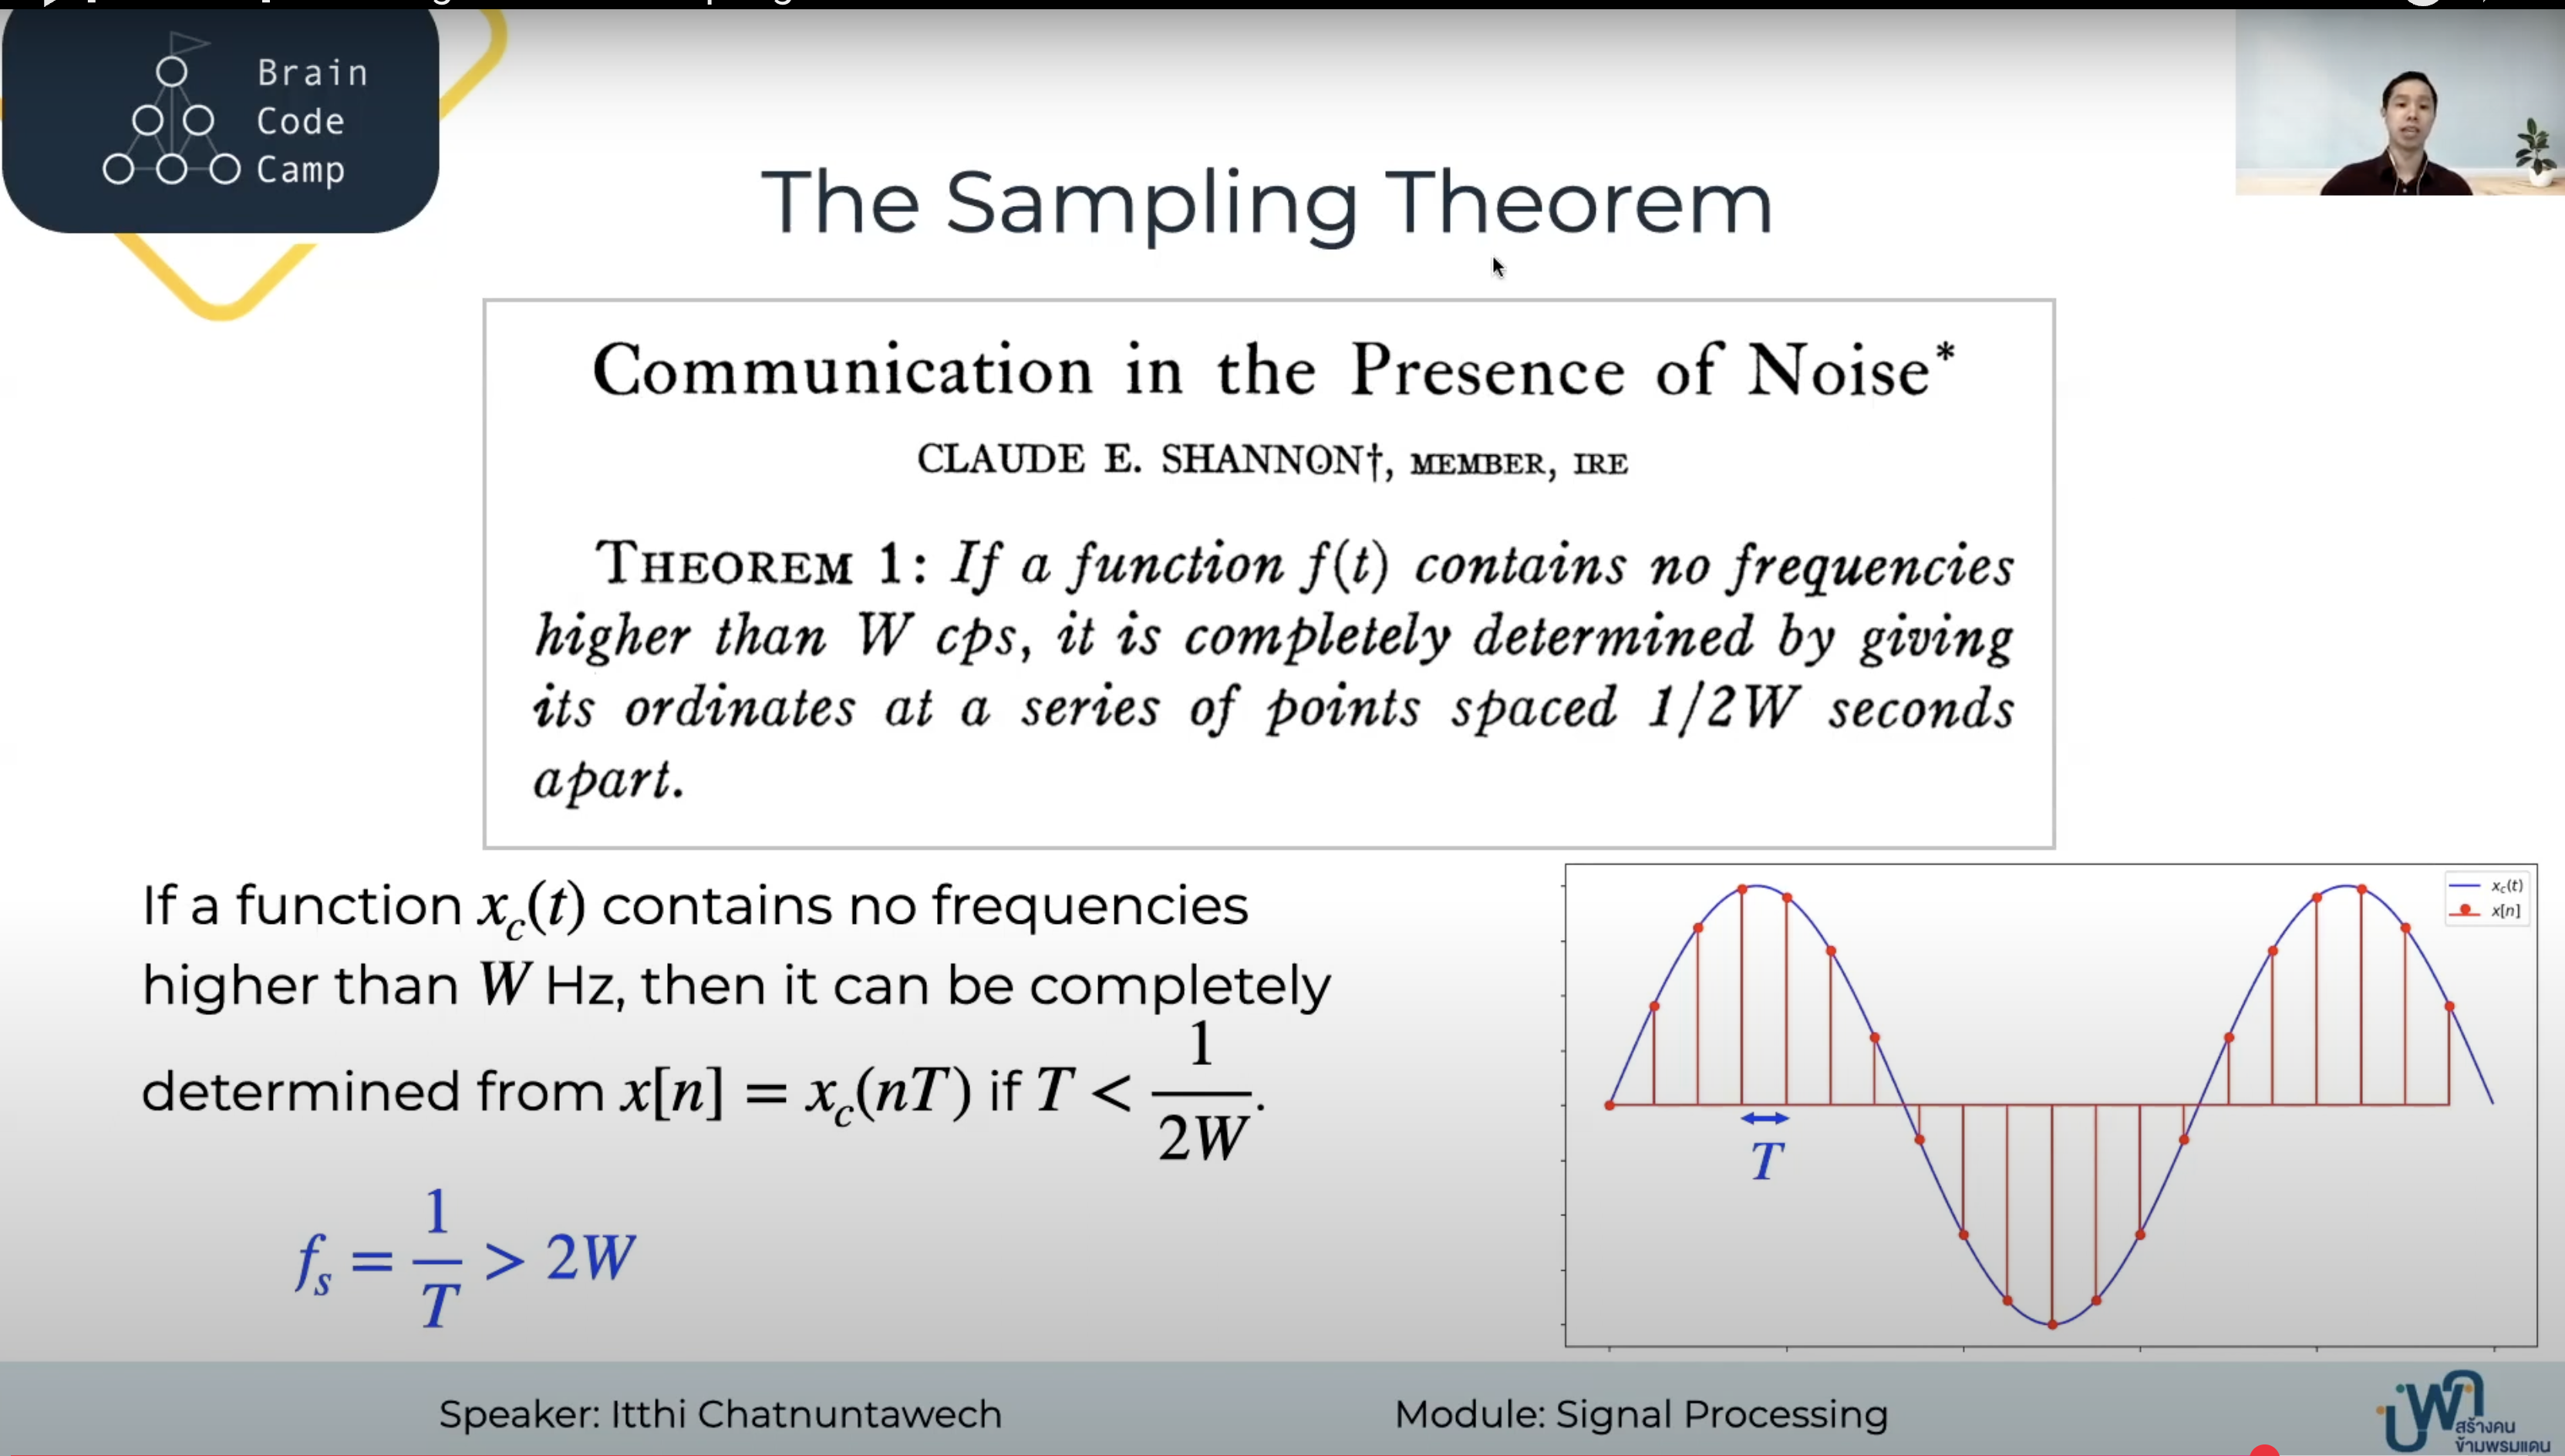

In [62]:
long_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204192 entries, 89 to 204039
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   station_name     204192 non-null  object        
 1   Date             204192 non-null  datetime64[ns]
 2   Electricity(kW)  204070 non-null  float64       
 3   weekday          204192 non-null  int32         
 4   hour             204192 non-null  int32         
 5   timeofday        204192 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(2), object(1)
memory usage: 9.3+ MB


/tmp/ipykernel_36/2593532960.py:92: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts_resamp = ts_filt.resample(rule).mean().interpolate()


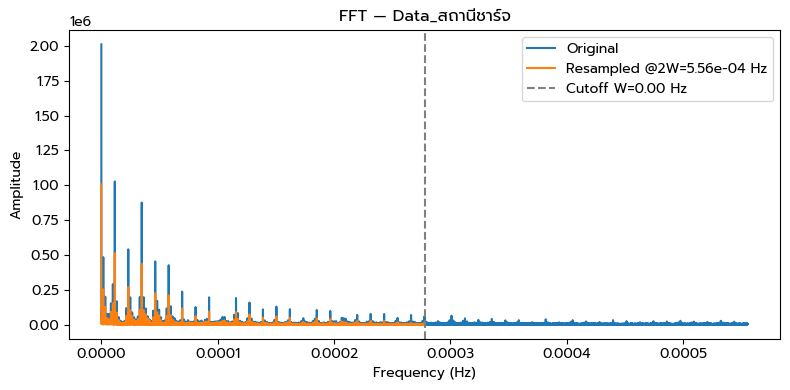

/tmp/ipykernel_36/2593532960.py:92: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts_resamp = ts_filt.resample(rule).mean().interpolate()


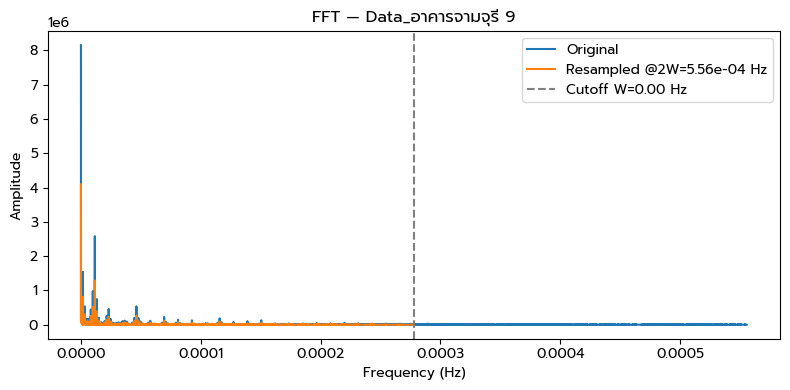

/tmp/ipykernel_36/2593532960.py:92: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts_resamp = ts_filt.resample(rule).mean().interpolate()


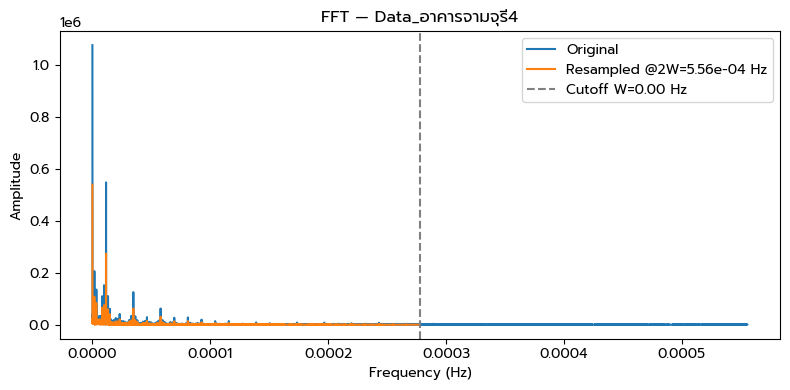

/tmp/ipykernel_36/2593532960.py:92: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts_resamp = ts_filt.resample(rule).mean().interpolate()


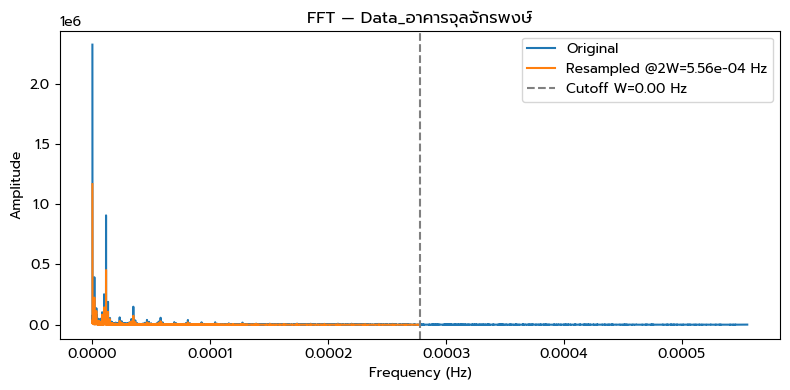

/tmp/ipykernel_36/2593532960.py:92: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts_resamp = ts_filt.resample(rule).mean().interpolate()


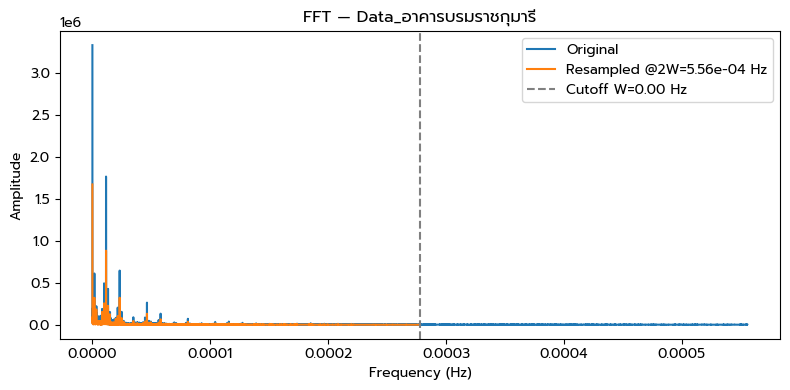

/tmp/ipykernel_36/2593532960.py:92: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts_resamp = ts_filt.resample(rule).mean().interpolate()


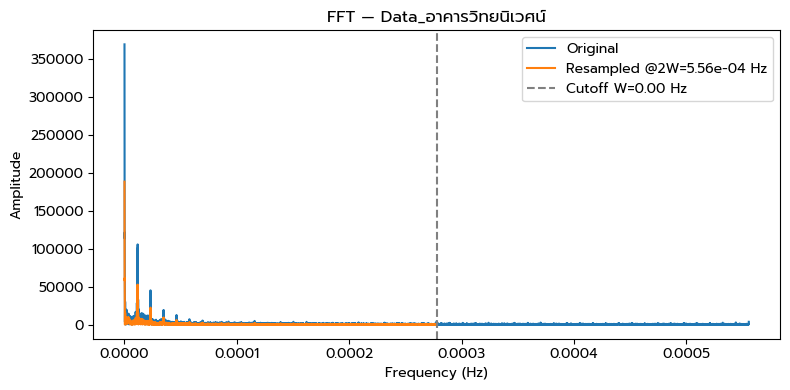

Resampled data written to 'long_df_resampled.csv'


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def lowpass_filter(y, fs, cutoff, order=4):
    """
    Apply a zero-phase Butterworth low-pass filter.
    
    Parameters
    ----------
    y : array-like
        Input signal.
    fs : float
        Original sampling rate (Hz).
    cutoff : float
        Cutoff frequency (Hz).
    order : int
        Filter order.
    
    Returns
    -------
    y_filt : ndarray
        Filtered signal.
    """
    b, a = butter(order, cutoff / (fs / 2), btype='low')
    return filtfilt(b, a, y)

def compute_fft(y, times):
    """
    Compute one‐sided FFT magnitude of a real signal.
    
    Parameters
    ----------
    y : array-like
        Real-valued signal.
    times : array-like of datetime64
        Timestamps corresponding to y.
    
    Returns
    -------
    xf : ndarray
        Frequencies (Hz), non-negative.
    amp : ndarray
        Corresponding FFT magnitudes.
    """
    n  = len(y)
    dt = (times[1] - times[0]).total_seconds()
    yf = np.fft.fft(y)
    xf = np.fft.fftfreq(n, d=dt)
    mask = xf >= 0
    return xf[mask], np.abs(yf[mask])

def process_station(grp, alpha=0.5, order=4):
    """
    Filter & downsample one station’s time series.

    Parameters
    ----------
    grp : DataFrame
        Subset of long_df for one station, sorted by Date.
    alpha : float
        Fraction of Nyquist to use as cutoff (0<alpha<=1).
    order : int
        Butterworth filter order.

    Returns
    -------
    out : DataFrame
        Resampled DataFrame with columns ['station_name','Date','Electricity(kW)'].
    fft_orig : tuple (xf_o, amp_o)
    fft_new  : tuple (xf_n, amp_n)
    W        : float
        Cutoff frequency used.
    """
    # original ts & sampling
    ts = grp.set_index('Date')['Electricity(kW)'].fillna(0)
    dt = (ts.index[1] - ts.index[0]).total_seconds()
    fs = 1.0 / dt

    # cutoff = alpha * Nyquist
    W = alpha * (fs / 2)

    # low-pass filter
    y_filt  = lowpass_filter(ts.values, fs, W, order=order)
    ts_filt = pd.Series(y_filt, index=ts.index)

    # resample: new sampling interval = 1/(2W)
    dt_new = 1.0 / (2 * W)
    rule   = f'{int(dt_new)}S'     # e.g. "30S" for 30-second steps
    ts_resamp = ts_filt.resample(rule).mean().interpolate()
    out = ts_resamp.rename('Electricity(kW)').reset_index()
    out['station_name'] = grp['station_name'].iloc[0]

    # compute FFTs
    xf_o, amp_o = compute_fft(ts.values, ts.index)
    xf_n, amp_n = compute_fft(ts_resamp.values, ts_resamp.index)

    return out[['station_name','Date','Electricity(kW)']], (xf_o, amp_o), (xf_n, amp_n), W

def main():
    # --- load your data: either assume long_df is already in memory,
    # or uncomment the next line to read from CSV ---
    # long_df = pd.read_csv('long_df.csv', parse_dates=['Date'])

    # ensure sorted
    long_df_sorted = long_df.sort_values(['station_name', 'Date'])
    
    records = []
    for station, grp in long_df_sorted.groupby('station_name'):
        out, (xf_o, amp_o), (xf_n, amp_n), W = process_station(grp, alpha=0.5, order=4)
        records.append(out)
        
        # plot FFTs for sanity
        plt.figure(figsize=(8,4))
        plt.plot(xf_o, amp_o, label='Original')
        plt.plot(xf_n, amp_n, label=f'Resampled @2W={2*W:.2e} Hz')
        plt.axvline(W, color='gray', linestyle='--', label=f'Cutoff W={W:.2f} Hz')
        plt.title(f'FFT — {station}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # concatenate all stations
    long_df_new = pd.concat(records, ignore_index=True)

    # optional: save to CSV
    long_df_new.to_csv('long_df_resampled.csv', index=False)
    print("Resampled data written to 'long_df_resampled.csv'")

if __name__ == '__main__':
    main()

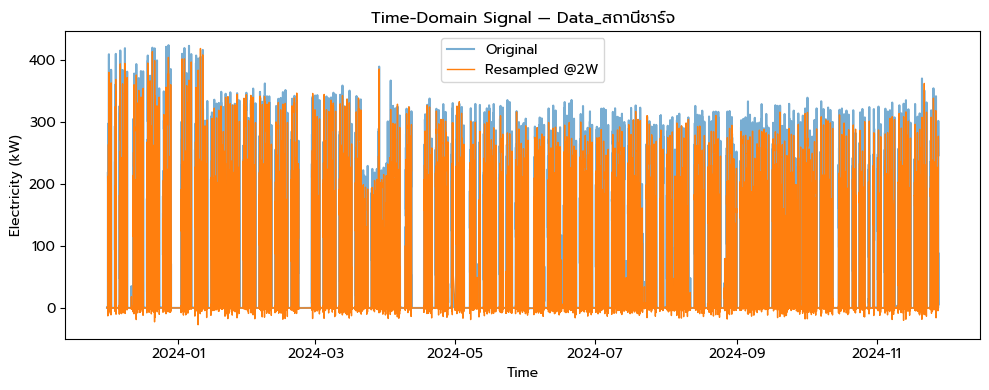

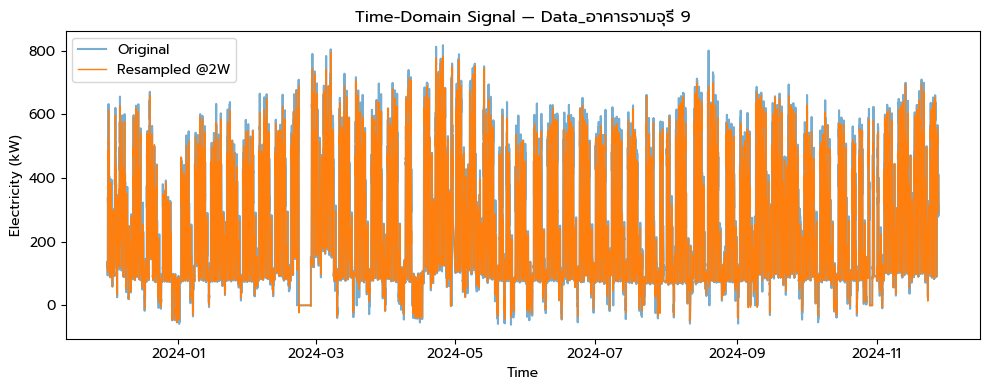

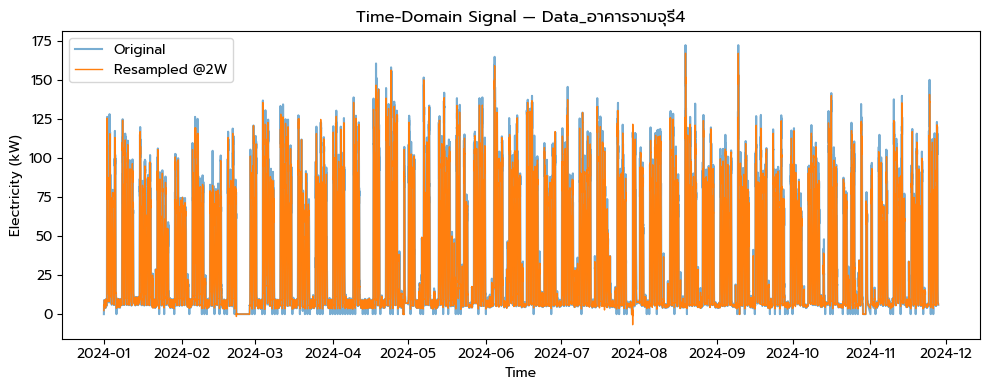

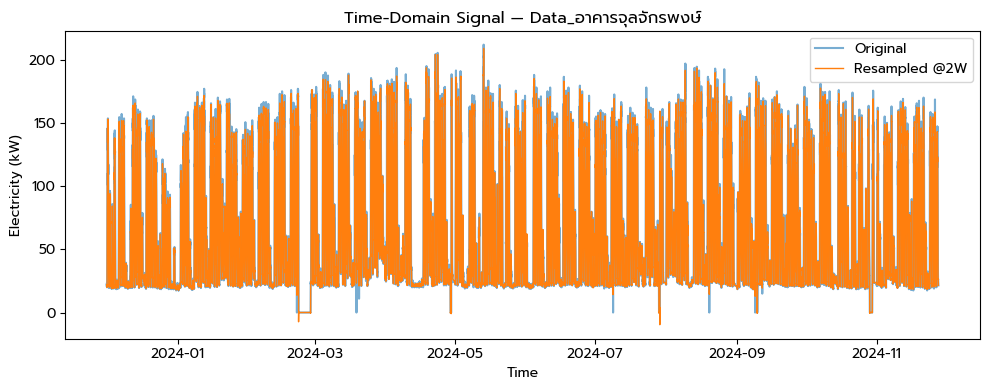

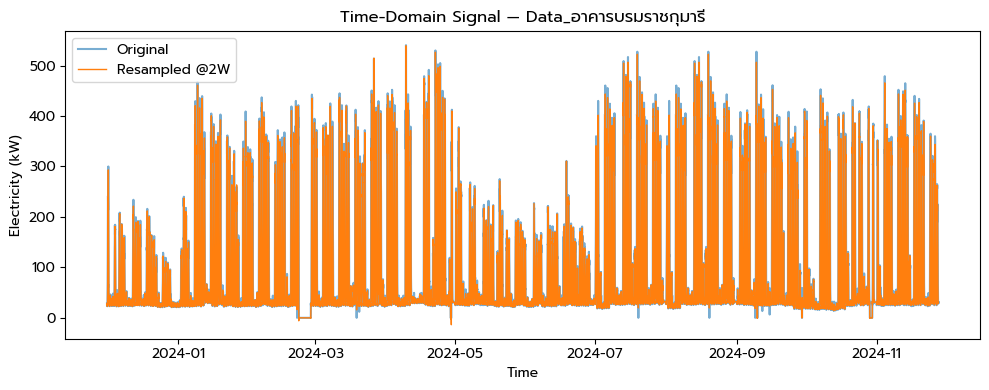

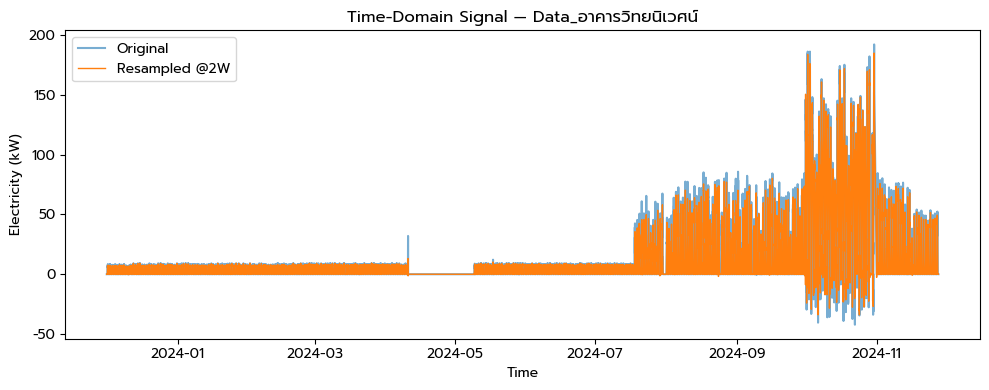

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you’ve already run the previous code block
# and have both `long_df` and `long_df_new` in scope.

# If you only want to plot a subset (e.g. first 5 stations), you can slice:
stations = long_df['station_name'].unique()

for station in stations:
    # original series
    orig = (
        long_df
        [long_df['station_name'] == station]
        .set_index('Date')['Electricity(kW)']
        .fillna(0)
    )
    
    # filtered & resampled series
    new   = (
        long_df_new
        [long_df_new['station_name'] == station]
        .set_index('Date')['Electricity(kW)']
        .fillna(0)
    )
    
    plt.figure(figsize=(10, 4))
    plt.plot(orig.index, orig.values,   label='Original',  alpha=0.6)
    plt.plot(new.index,   new.values,   label='Resampled @2W', linewidth=1)
    plt.title(f"Time-Domain Signal — {station}")
    plt.xlabel("Time")
    plt.ylabel("Electricity (kW)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [44]:
long_df

station_name                Date  Electricity(kW)
89            Data_สถานีชาร์จ 2023-12-01 00:00:00             0.57
2216          Data_สถานีชาร์จ 2023-12-01 00:15:00             1.08
4343          Data_สถานีชาร์จ 2023-12-01 00:30:00             0.70
6470          Data_สถานีชาร์จ 2023-12-01 00:45:00             0.89
8597          Data_สถานีชาร์จ 2023-12-01 01:00:00             1.01
...                       ...                 ...              ...
195531  Data_อาคารวิทยนิเวศน์ 2024-11-27 22:45:00             0.00
197658  Data_อาคารวิทยนิเวศน์ 2024-11-27 23:00:00             0.00
199785  Data_อาคารวิทยนิเวศน์ 2024-11-27 23:15:00             0.00
201912  Data_อาคารวิทยนิเวศน์ 2024-11-27 23:30:00             0.00
204039  Data_อาคารวิทยนิเวศน์ 2024-11-27 23:45:00             0.03

[204192 rows x 3 columns]

In [45]:
long_df_new

station_name                Date  Electricity(kW)
0             Data_สถานีชาร์จ 2023-12-01 00:00:00         0.684962
1             Data_สถานีชาร์จ 2023-12-01 00:30:00         0.933056
2             Data_สถานีชาร์จ 2023-12-01 01:00:00         0.720951
3             Data_สถานีชาร์จ 2023-12-01 01:30:00         0.426339
4             Data_สถานีชาร์จ 2023-12-01 02:00:00         0.730438
...                       ...                 ...              ...
103051  Data_อาคารวิทยนิเวศน์ 2024-11-27 21:30:00         0.000256
103052  Data_อาคารวิทยนิเวศน์ 2024-11-27 22:00:00        -0.000456
103053  Data_อาคารวิทยนิเวศน์ 2024-11-27 22:30:00         0.000976
103054  Data_อาคารวิทยนิเวศน์ 2024-11-27 23:00:00        -0.002363
103055  Data_อาคารวิทยนิเวศน์ 2024-11-27 23:30:00         0.017841

[103056 rows x 3 columns]

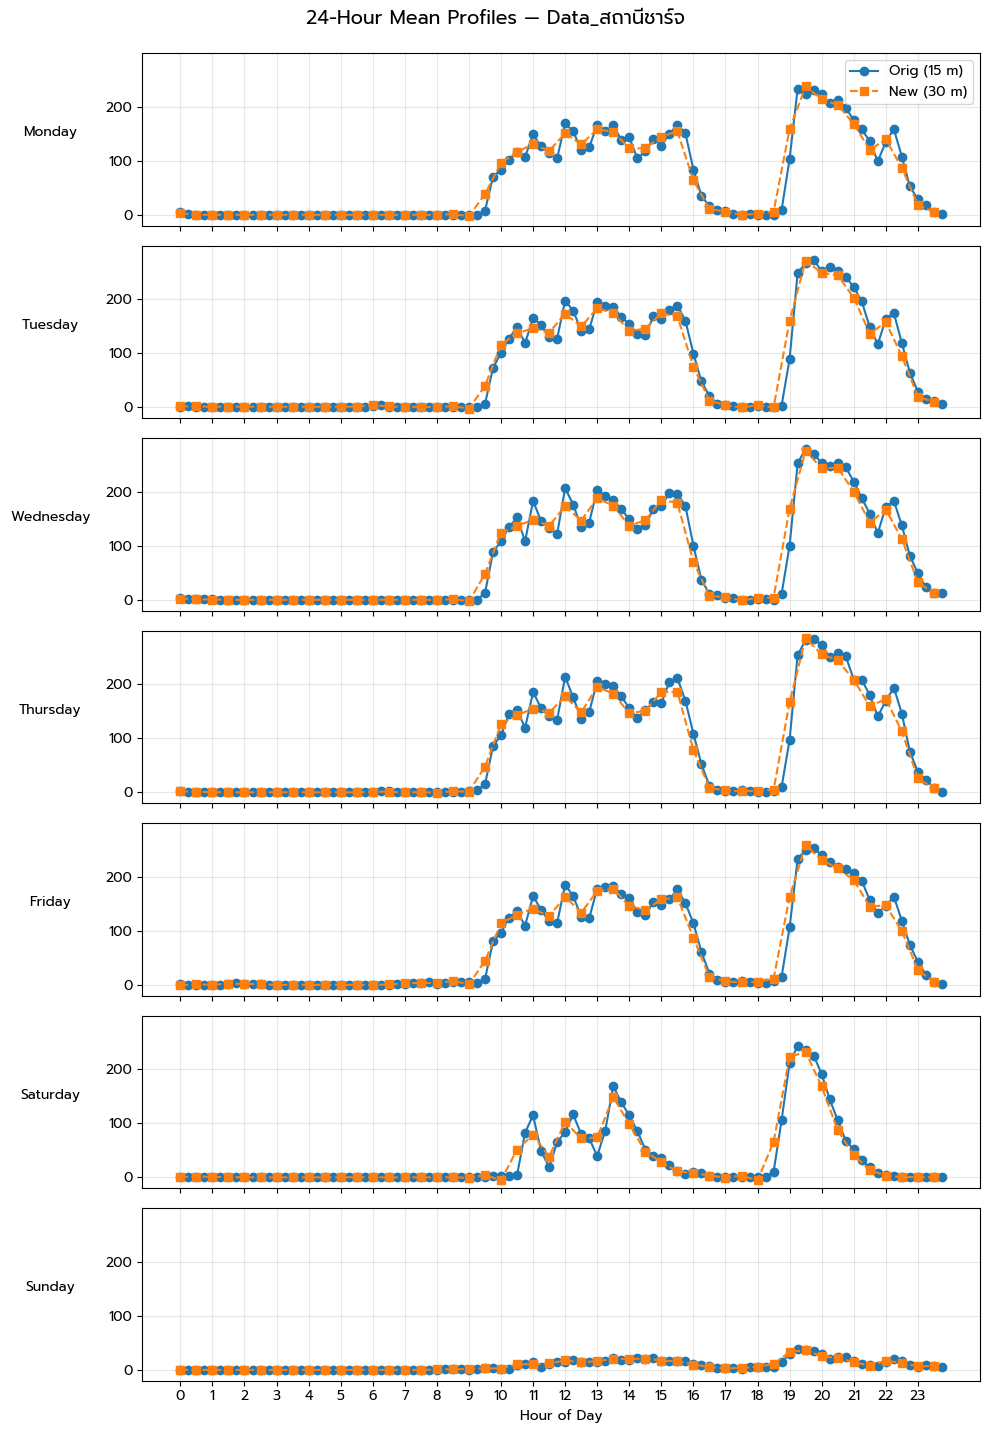

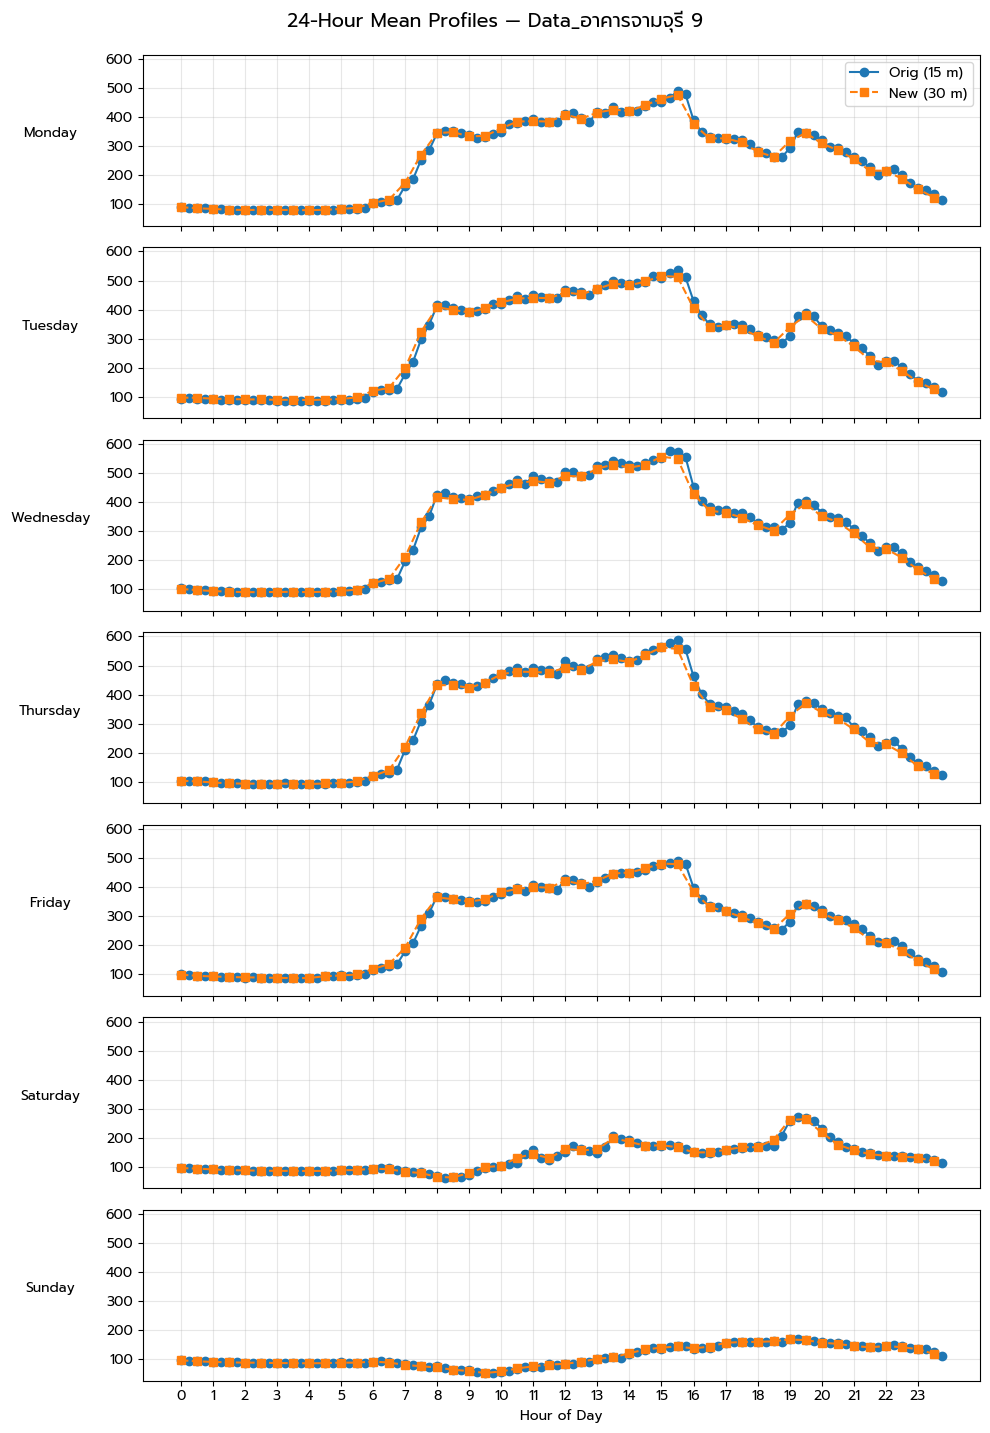

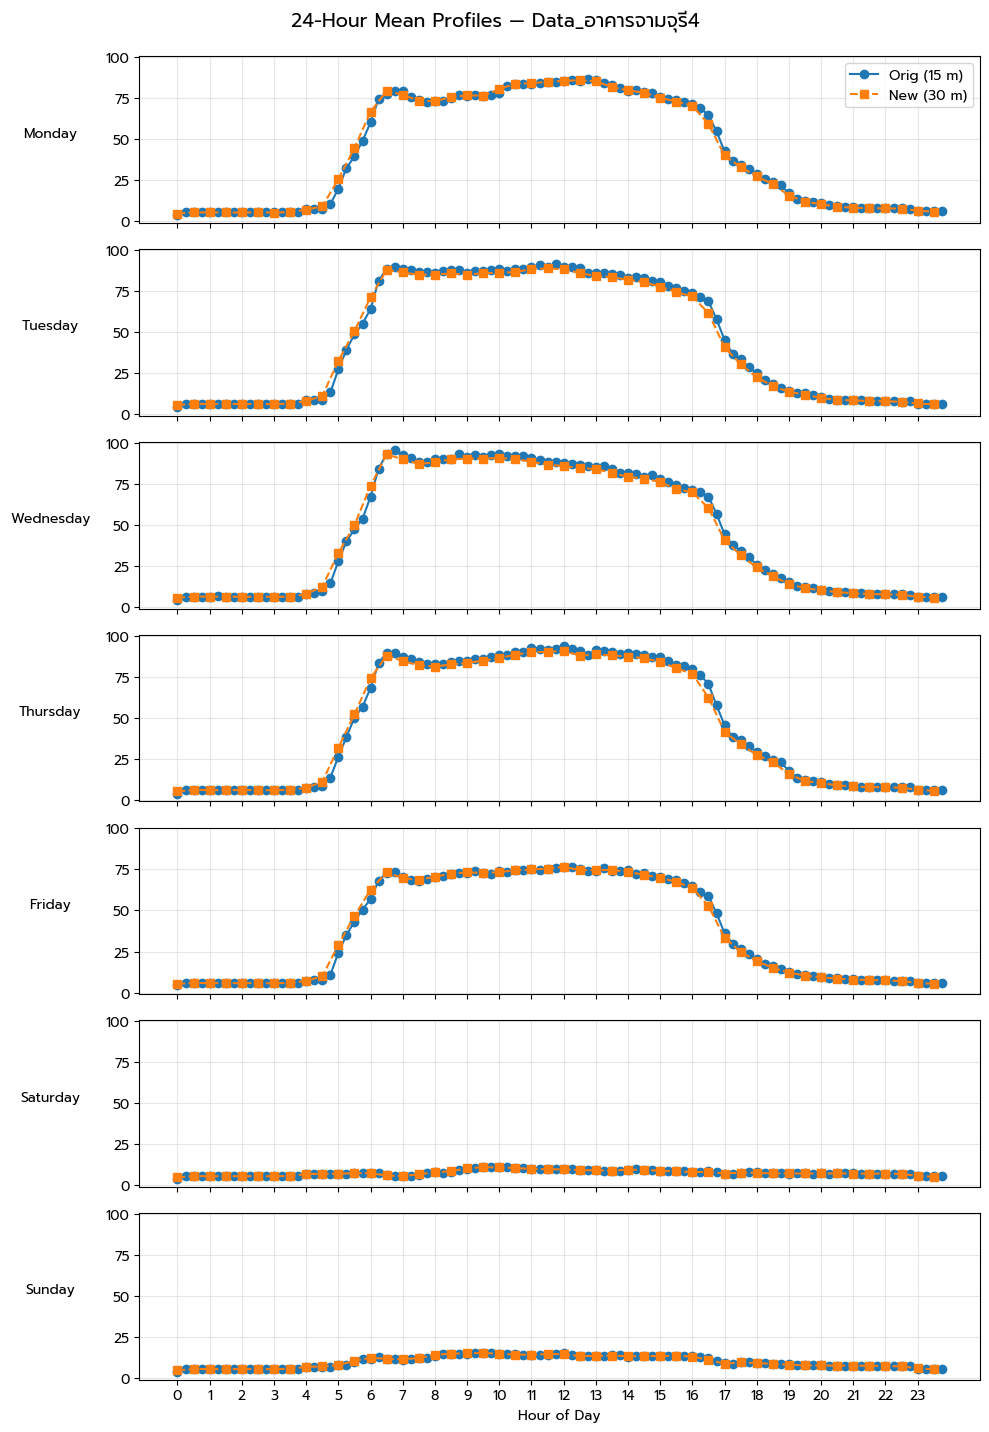

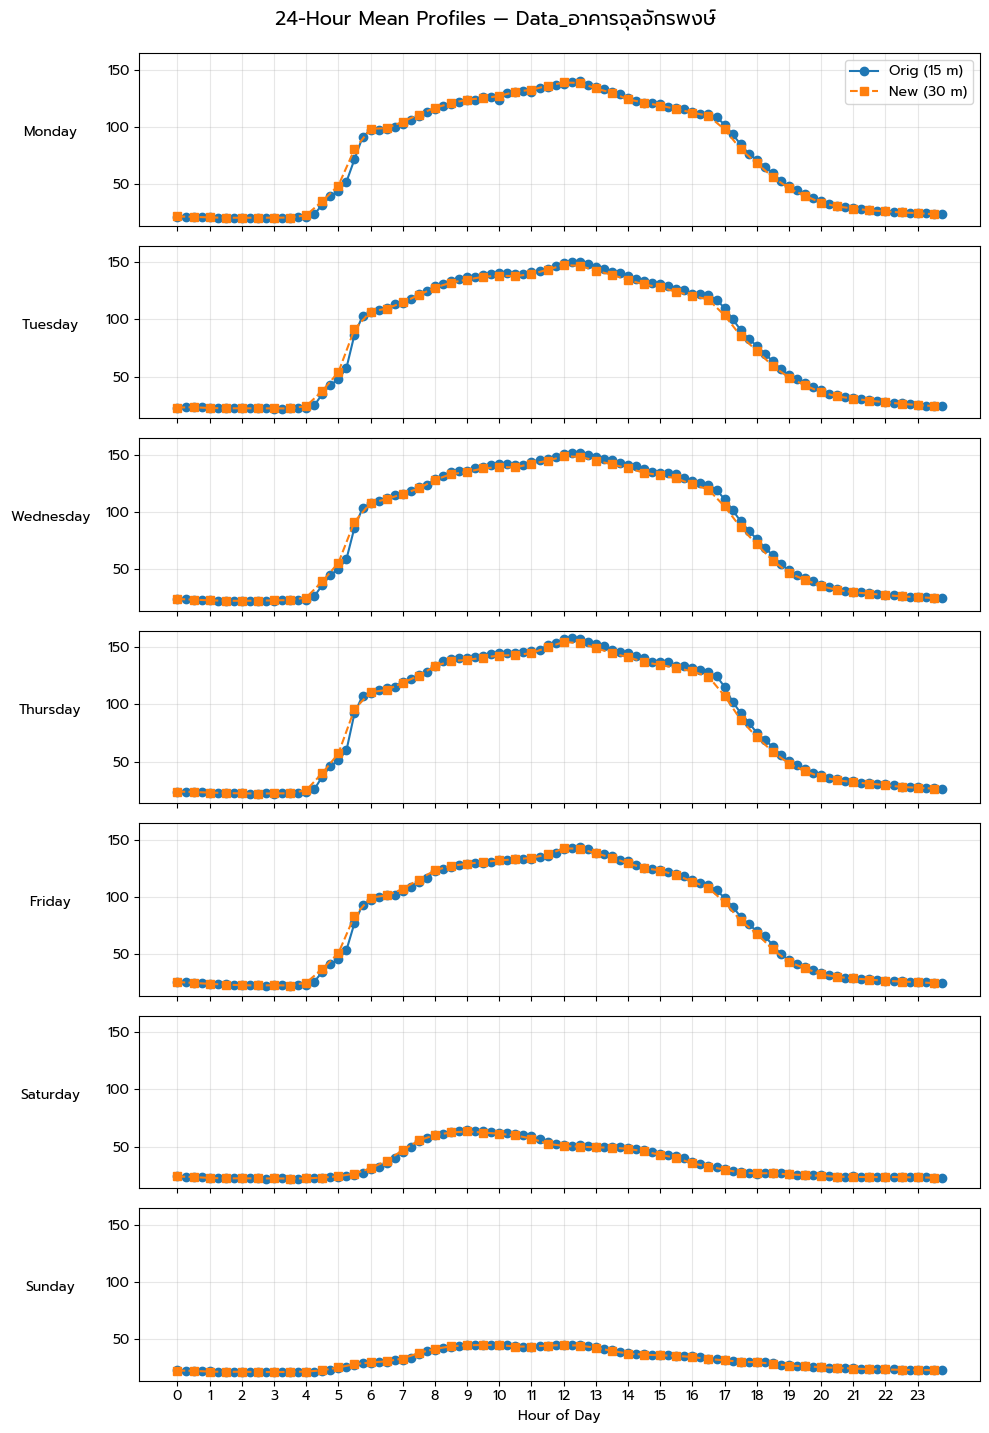

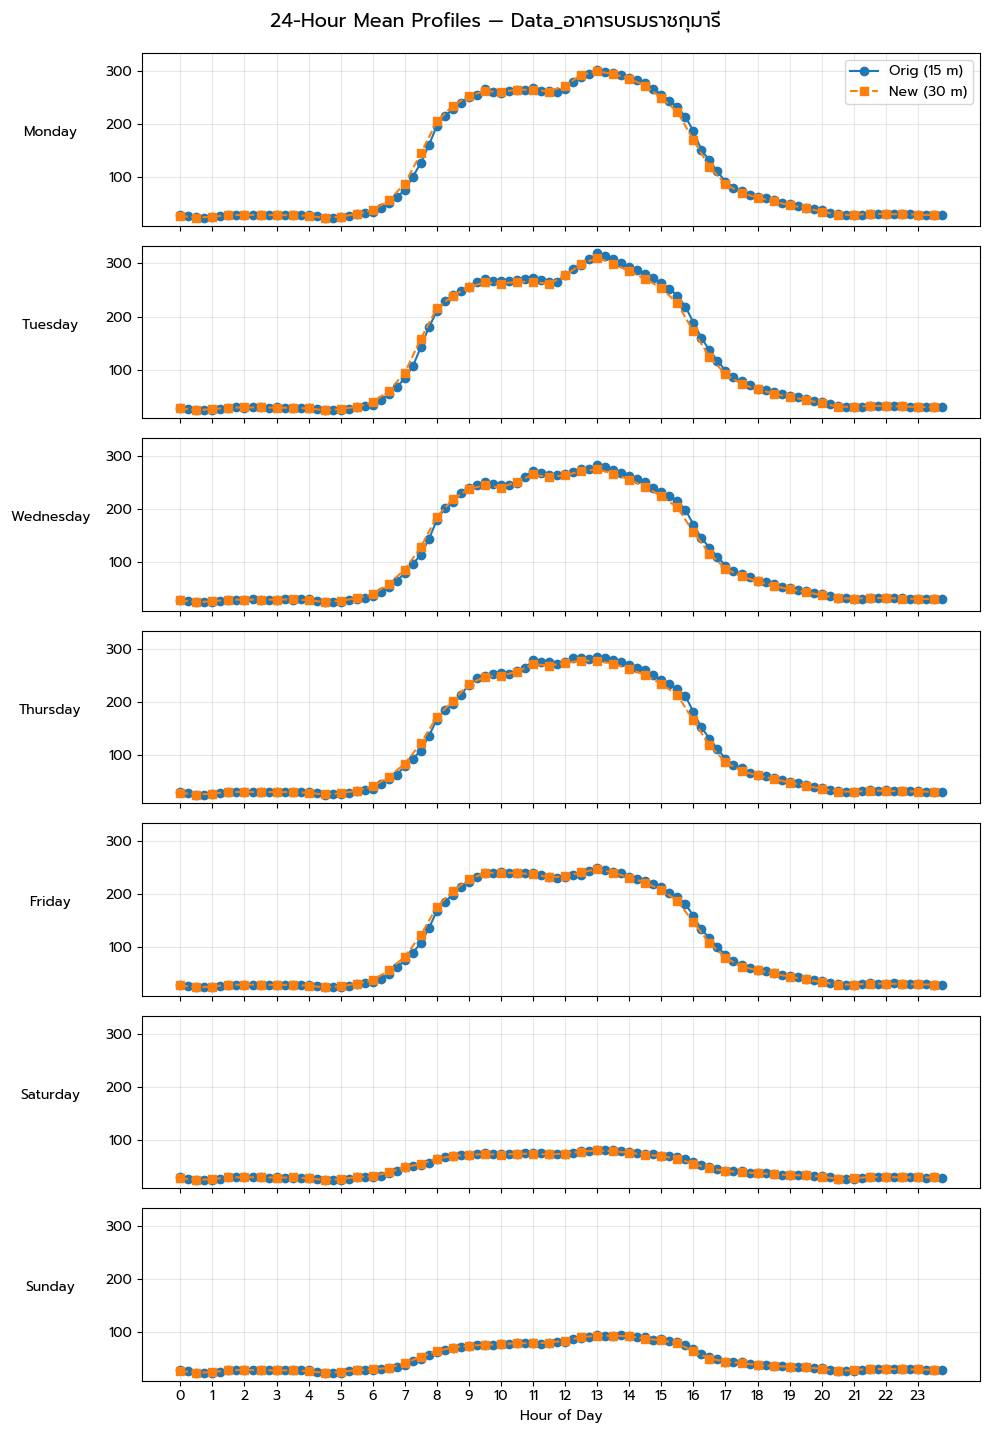

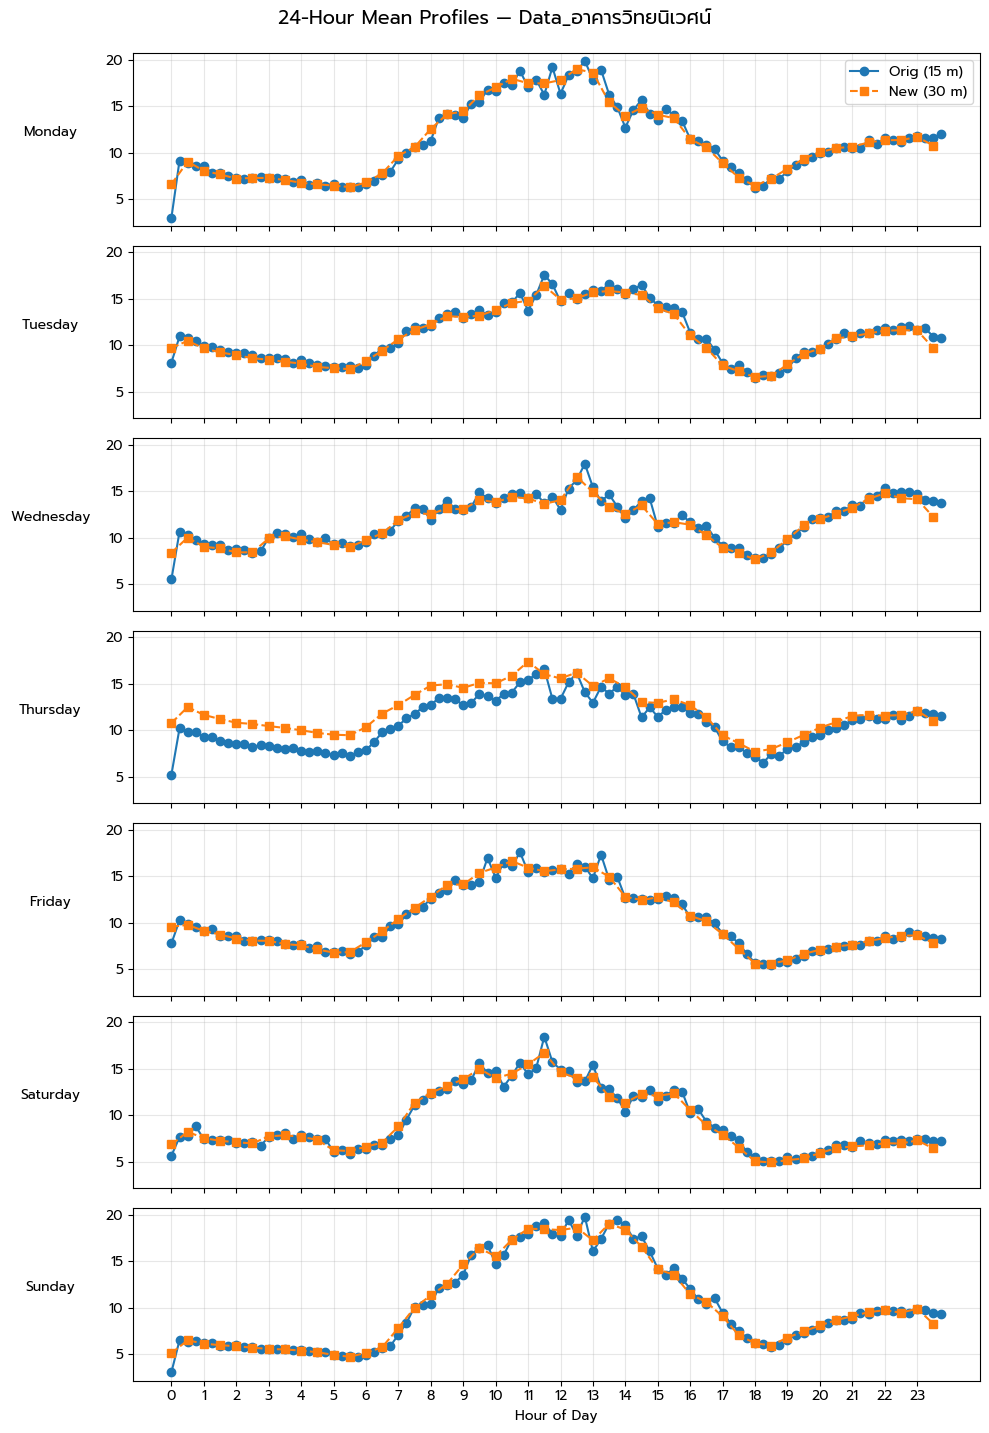

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import calendar

def plot_weekly_time_profile(orig_df, new_df, station):
    # --- 1) Subset & annotate ---
    o = orig_df[orig_df['station_name'] == station].copy()
    n = new_df[new_df['station_name'] == station].copy()
    for df in (o, n):
        # weekday 0=Mon … 6=Sun
        df['weekday'] = df['Date'].dt.dayofweek
        # convert exact timestamp → fractional hour (e.g. 13.25 for 13:15)
        df['hour_f'] = df['Date'].dt.hour + df['Date'].dt.minute / 60

    # --- 2) Group & average by (weekday, hour_f) ---
    weekly_o = (
        o
        .groupby(['weekday','hour_f'])['Electricity(kW)']
        .mean()
        .reset_index()
    )
    weekly_n = (
        n
        .groupby(['weekday','hour_f'])['Electricity(kW)']
        .mean()
        .reset_index()
    )

    # --- 3) Plot a 7-row stack (one subplot per weekday) ---
    fig, axes = plt.subplots(
        nrows=7, ncols=1,
        sharex=True, sharey=True,
        figsize=(10, 14)
    )

    for wd in range(7):
        ax = axes[wd]
        d_o = weekly_o[weekly_o['weekday'] == wd]
        d_n = weekly_n[weekly_n['weekday'] == wd]

        ax.plot(
            d_o['hour_f'], d_o['Electricity(kW)'],
            marker='o', linestyle='-',
            label='Orig (15 m)'
        )
        ax.plot(
            d_n['hour_f'], d_n['Electricity(kW)'],
            marker='s', linestyle='--',
            label='New (30 m)'
        )

        ax.set_ylabel(calendar.day_name[wd], rotation=0, labelpad=40)
        ax.grid(alpha=0.3)

        # only show legend on the first subplot
        if wd == 0:
            ax.legend(loc='upper right')

    # --- 4) Final formatting ---
    axes[-1].set_xlabel('Hour of Day')
    plt.xticks(np.arange(0, 24, 1))
    plt.tight_layout()
    plt.suptitle(f'24-Hour Mean Profiles — {station}', y=1.02, fontsize=14)
    plt.show()


# -------------------------
# 5) Loop over your stations
# -------------------------
stations = long_df['station_name'].unique()
for st in stations:
    plot_weekly_time_profile(long_df, long_df_new, st)

## Define Weight

In [70]:
import pandas as pd

# Create the DataFrame
station_weights_df = pd.DataFrame({
    "station_name": [
        "Data_สถานีชาร์จ",
        "Data_อาคารจามจุรี 9",
        "Data_อาคารวิทยนิเวศน์",
        "Data_อาคารจุลจักรพงษ์",
        "Data_อาคารบรมราชกุมารี",
        "Data_อาคารจามจุรี4",
    ],
    "normalized_reverse_weight": [
        1.000000,
        1.000000,
        1.000000,
        1.002786,
        1.002786,
        1.094225,
    ]
})

## Experiment [Clean Data]

In [71]:
long_df_new

station_name                Date  Electricity(kW)
0             Data_สถานีชาร์จ 2023-12-01 00:00:00         0.684962
1             Data_สถานีชาร์จ 2023-12-01 00:30:00         0.933056
2             Data_สถานีชาร์จ 2023-12-01 01:00:00         0.720951
3             Data_สถานีชาร์จ 2023-12-01 01:30:00         0.426339
4             Data_สถานีชาร์จ 2023-12-01 02:00:00         0.730438
...                       ...                 ...              ...
103051  Data_อาคารวิทยนิเวศน์ 2024-11-27 21:30:00         0.000256
103052  Data_อาคารวิทยนิเวศน์ 2024-11-27 22:00:00        -0.000456
103053  Data_อาคารวิทยนิเวศน์ 2024-11-27 22:30:00         0.000976
103054  Data_อาคารวิทยนิเวศน์ 2024-11-27 23:00:00        -0.002363
103055  Data_อาคารวิทยนิเวศน์ 2024-11-27 23:30:00         0.017841

[103056 rows x 3 columns]

In [77]:
def preprocess(long_df):
    long_df.loc[long_df['Electricity(kW)'] < 0, 'Electricity(kW)'] = 0
    return long_df
long_df_tmp = preprocess(long_df_new)
long_df = preprocess(long_df)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


## Split train,valid and test

In [87]:
def split_train_test_data(long_df,long_df_new):
    # Define ratios
    train_ratio = 0.8
    test_ratio = 0.2  # Optional, just for clarity (1 - train_ratio)
    
    # Create empty lists to collect per-station splits
    train_list = []
    test_list = []
    
    # Split per station
    for station, station_df in long_df_new.groupby('station_name'):
        station_df = station_df.sort_values('Date')
        n = len(station_df)
    
        train_end = int(n * train_ratio)
    
        train_list.append(station_df.iloc[:train_end])
        test_list.append(station_df.iloc[train_end:])
    
    # Combine all stations back into global sets
    train_df = pd.concat(train_list).reset_index(drop=True)
    # Create empty lists to collect per-station splits
    train_list = []
    test_list = []
    for station, station_df in long_df.groupby('station_name'):
        station_df = station_df.sort_values('Date')
        n = len(station_df)
    
        train_end = int(n * train_ratio)
    
        train_list.append(station_df.iloc[:train_end])
        test_list.append(station_df.iloc[train_end:])
    
    test_df_new = pd.concat(test_list).reset_index(drop=True)
    
    return train_df,test_df_new
train_df,test_df = split_train_test_data(long_df,long_df_tmp)

In [88]:
train_df = train_df.drop(columns=["Electricity(kW)"	,"weekday",	"hour",	"timeofday"])

KeyError: "['weekday', 'hour', 'timeofday'] not found in axis"

In [2]:
import pandas as pd
train_df = pd.read_parquet("/kaggle/input/datasetembedding/Train with Embedding.parquet")
test_df = pd.read_parquet("/kaggle/input/datasetembedding/Test with Embedding.parquet")

In [84]:
locations = {
    "Data_สถานีชาร์จ": (13.73624, 100.52995),
    "Data_อาคารจามจุรี4": (13.73260, 100.53177),
    "Data_อาคารจามจุรี 9": (13.73380, 100.53045),
    "Data_อาคารจุลจักรพงษ์": (13.73684, 100.52852),
    "Data_อาคารบรมราชกุมารี": (13.73800, 100.52905),
    "Data_อาคารวิทยนิเวศน์": (13.73723, 100.53015),
}


In [ ]:
!pip install torch-geometric-temporal

## Node2Vec

In [ ]:
!pip install torch-cluster # then restart

In [4]:
locations = {
    "Data_สถานีชาร์จ": (13.73624, 100.52995),
    "Data_อาคารจามจุรี4": (13.73260, 100.53177),
    "Data_อาคารจามจุรี 9": (13.73380, 100.53045),
    "Data_อาคารจุลจักรพงษ์": (13.73684, 100.52852),
    "Data_อาคารบรมราชกุมารี": (13.73800, 100.52905),
    "Data_อาคารวิทยนิเวศน์": (13.73723, 100.53015),
}

def add_spatial_embeddings(
    df,
    locations: dict,
    embedding_dim: int = 16,
    k: int = 3,
    num_epochs: int = 100,
    walk_length: int = 10,
    context_size: int = 5,
    walks_per_node: int = 20,
    lr: float = 0.01,
    seed: int = 42,
):
    """
    Learn Node2Vec embeddings for each station in `locations`
    and merge them into `df` as static numeric features.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain a 'station_name' column (item_id for AutoGluon).
    locations : dict
        {station_name: (lat, lon)}
    embedding_dim : int
        Size of the learned vector.
    k : int
        Number of nearest neighbours used to build the undirected graph.
    num_epochs : int
        Optimisation steps for Node2Vec.
    walk_length, context_size, walks_per_node, lr, seed
        Standard Node2Vec hyper-parameters.

    Returns
    -------
    df_out : pandas.DataFrame
        Original `df` plus columns emb_0 … emb_{embedding_dim-1}`.
    """

    import numpy as np
    import pandas as pd
    import torch
    from sklearn.neighbors import NearestNeighbors
    from torch_geometric.nn.models import Node2Vec

    torch.manual_seed(seed)
    np.random.seed(seed)

    # ------------------------------------------------------------------
    # 1. Build k-NN edge index
    # ------------------------------------------------------------------
    node_names = list(locations.keys())
    coords = np.array([locations[n] for n in node_names])
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm="ball_tree").fit(coords)
    _, indices = nbrs.kneighbors(coords)

    edge_index = []
    for i, neigh in enumerate(indices):
        for j in neigh[1:]:  # first neighbour is the node itself
            edge_index.append([i, j])
            edge_index.append([j, i])  # undirected
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # ------------------------------------------------------------------
    # 2. Train Node2Vec
    # ------------------------------------------------------------------
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = Node2Vec(
        edge_index=edge_index,
        embedding_dim=embedding_dim,
        walk_length=walk_length,
        context_size=context_size,
        walks_per_node=walks_per_node,
        sparse=True,
    ).to(device)

    loader = model.loader(batch_size=128, shuffle=True, num_workers=0)
    optimiser = torch.optim.SparseAdam(model.parameters(), lr=lr)

    model.train()
    for _ in range(num_epochs):
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimiser.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimiser.step()
            total_loss += loss.item()

    # ------------------------------------------------------------------
    # 3. Build embedding DataFrame
    # ------------------------------------------------------------------
    model.eval()
    with torch.no_grad():
        embeds = model.embedding.weight.cpu().numpy()

    emb_df = (
        pd.DataFrame(embeds, columns=[f"emb_{i}" for i in range(embedding_dim)])
        .assign(station_name=node_names)
    )

    # ------------------------------------------------------------------
    # 4. Merge and return
    # ------------------------------------------------------------------
    df_out = df.merge(emb_df, on="station_name", how="left")

    return df_out

In [5]:
train_df_enriched = add_spatial_embeddings(train_df, locations, embedding_dim=16)
test_df_enriched = add_spatial_embeddings(test_df, locations, embedding_dim=16)

In [7]:
train_df_enriched.to_parquet("train_with_embedding.parquet",index=False)
test_df_enriched.to_parquet("test_with_embedding.parquet",index=False)

## Modeling

In [72]:
!pip install -U autogluon.timeseries

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.4/382.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 22.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [89]:
train_df

station_name                Date  Electricity(kW)
0            Data_สถานีชาร์จ 2023-12-01 00:00:00         0.684962
1            Data_สถานีชาร์จ 2023-12-01 00:30:00         0.933056
2            Data_สถานีชาร์จ 2023-12-01 01:00:00         0.720951
3            Data_สถานีชาร์จ 2023-12-01 01:30:00         0.426339
4            Data_สถานีชาร์จ 2023-12-01 02:00:00         0.730438
...                      ...                 ...              ...
82438  Data_อาคารวิทยนิเวศน์ 2024-09-16 07:00:00         6.503255
82439  Data_อาคารวิทยนิเวศน์ 2024-09-16 07:30:00        10.358435
82440  Data_อาคารวิทยนิเวศน์ 2024-09-16 08:00:00        16.852501
82441  Data_อาคารวิทยนิเวศน์ 2024-09-16 08:30:00        38.267459
82442  Data_อาคารวิทยนิเวศน์ 2024-09-16 09:00:00        50.229167

[82443 rows x 3 columns]

In [90]:
test_df

station_name                Date  Electricity(kW)  weekday  \
0            Data_สถานีชาร์จ 2024-09-16 00:00:00             0.13        0   
1            Data_สถานีชาร์จ 2024-09-16 00:15:00             0.13        0   
2            Data_สถานีชาร์จ 2024-09-16 00:30:00             0.13        0   
3            Data_สถานีชาร์จ 2024-09-16 00:45:00             0.12        0   
4            Data_สถานีชาร์จ 2024-09-16 01:00:00             0.01        0   
...                      ...                 ...              ...      ...   
40834  Data_อาคารวิทยนิเวศน์ 2024-11-27 22:45:00             0.00        2   
40835  Data_อาคารวิทยนิเวศน์ 2024-11-27 23:00:00             0.00        2   
40836  Data_อาคารวิทยนิเวศน์ 2024-11-27 23:15:00             0.00        2   
40837  Data_อาคารวิทยนิเวศน์ 2024-11-27 23:30:00             0.00        2   
40838  Data_อาคารวิทยนิเวศน์ 2024-11-27 23:45:00             0.03        2   

       hour  timeofday  
0         0       0.00  
1         0       0.25  
2         0       0.50  
3         0       0.75  
4         1       1.00  
...     ...        ...  
40834    22      22.75  
40835    23      23.00  
40836    23      23.25  
40837    23      23.50  
40838    23      23.75  

[40839 rows x 6 columns]

In [102]:
import pandas as pd
import numpy as np
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
# train_df = train_df_enriched.copy()
# test_df = test_df_enriched.copy()


train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

train_df['item_id'] = train_df['station_name']
test_df['item_id'] = test_df['station_name']

# 2. Convert to TimeSeriesDataFrame
train_data = TimeSeriesDataFrame.from_data_frame(train_df, id_column='item_id', timestamp_column='Date')
test_data = TimeSeriesDataFrame.from_data_frame(test_df, id_column='item_id', timestamp_column='Date')

# 3. Set prediction length (e.g., 96 steps = next 24 hours for 15min freq)
prediction_length = 96
freq = "15min"

# 4. Train the predictor
predictor = TimeSeriesPredictor(
    label="Electricity(kW)",
    prediction_length=prediction_length,
    eval_metric="mse",
    path="AutogluonTimeSeriesModels",
    freq=freq
)

predictor.fit(
    train_data=train_data,
    presets='best',
    enable_ensemble=False,
    time_limit=150,
    hyperparameters={
        'Chronos':
                    {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},

    }
)

Beginning AutoGluon training... Time limit = 150s
AutoGluon will save models to '/kaggle/working/AutogluonTimeSeriesModels'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
GPU Count:          0
Memory Avail:       28.65 GB / 31.35 GB (91.4%)
Disk Space Avail:   19.43 GB / 19.52 GB (99.5%)
Setting presets to: best

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': MSE,
 'freq': '15min',
 'hyperparameters': {'Chronos': {'ag_args': {'name_suffix': 'ZeroShot'},
                                 'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 96,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 '

In [93]:
import pandas as pd
from autogluon.timeseries.metrics import TimeSeriesScorer

class WeightedWAPE(TimeSeriesScorer):
    """
    Weighted Absolute Percentage Error (WAPE), where each series
    is weighted by a user‐provided mapping of normalized_reverse_weight.
    """
    greater_is_better_internal = False  # lower is better
    optimum = 0.0

    def __init__(self, prediction_length: int, station_weights: pd.Series):
        # Only pass prediction_length to the super; no `name=` argument.
        super().__init__(prediction_length=prediction_length)
        # station_weights: pd.Series indexed by item_id (i.e. station_name)
        self.station_weights = station_weights

    def compute_metric(self, data_future, predictions, target, **kwargs) -> float:
        """
        data_future[target]  : TimeSeriesDataFrame of true values over the forecast horizon
        predictions["mean"]  : TimeSeriesDataFrame of point forecasts over the same horizon
        """
        # Flatten out the multi‐index into aligned 1D arrays
        y_true = data_future[target]      # pd.Series, index: (item_id, timestamp)
        y_pred = predictions["mean"]      # pd.Series, same index

        # Extract the item_ids for each row in the forecast horizon
        item_ids = y_true.index.get_level_values("item_id")
        # Map to the weights you computed earlier
        weights  = pd.Series(item_ids).map(self.station_weights).to_numpy()

        abs_err    = (y_true - y_pred).abs().to_numpy()
        abs_actual = y_true.abs().to_numpy()

        weighted_error    = (weights * abs_err).sum()
        weighted_actual   = (weights * abs_actual).sum()
        return weighted_error / weighted_actual

In [103]:
from autogluon.timeseries import TimeSeriesPredictor
from autogluon.timeseries.metrics import SMAPE, MASE
# 1) turn your station_weights_df into a Series indexed by station_name
station_weights = station_weights_df.set_index("station_name")["normalized_reverse_weight"]

# 2) instantiate your metric
wwape = WeightedWAPE(
    prediction_length=predictor.prediction_length,
    station_weights=station_weights
)


# Now call leaderboard on your held-out data, asking for extra metrics:
lb = predictor.leaderboard(
    data=test_data,
    extra_metrics=[
        "MSE",
        "MAE",        # mean absolute error
        SMAPE(),      # symmetric MAPE as a TimeSeriesScorer object
        MASE(),       # mean absolute scaled error as a TimeSeriesScorer object
        wwape
    ],
)
lb

data with frequency 'IRREG' has been resampled to frequency '15min'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


model   score_test    score_val  pred_time_test  \
0  ChronosZeroShot[bolt_small] -3011.428155 -1573.388504        2.122223   

   pred_time_val  fit_time_marginal  fit_order          MSE        MAE  \
0       2.184393           2.887409          1 -3011.428155 -26.001733   

      SMAPE      MASE  WeightedWAPE  
0 -0.533544 -0.577369     -0.248762

In [15]:
from autogluon.timeseries import TimeSeriesPredictor
from autogluon.timeseries.metrics import SMAPE, MASE
# 1) turn your station_weights_df into a Series indexed by station_name
station_weights = station_weights_df.set_index("station_name")["normalized_reverse_weight"]

# 2) instantiate your metric
wwape = WeightedWAPE(
    prediction_length=predictor.prediction_length,
    station_weights=station_weights
)


# Now call leaderboard on your held-out data, asking for extra metrics:
lb = predictor.leaderboard(
    data=test_data,
    extra_metrics=[
        "MSE",
        "MAE",        # mean absolute error
        SMAPE(),      # symmetric MAPE as a TimeSeriesScorer object
        MASE(),       # mean absolute scaled error as a TimeSeriesScorer object
        wwape
    ],
)
lb

data with frequency 'IRREG' has been resampled to frequency '15min'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


model    score_test     score_val  pred_time_test  \
0                       PatchTST  -1997.473668  -3444.548951        0.074719   
1                  DirectTabular  -2173.731599  -2219.393780        0.226535   
2          DynamicOptimizedTheta  -2528.016447 -10368.531838        4.630404   
3                         DeepAR  -2675.955988  -1615.551223        0.526300   
4               RecursiveTabular  -2701.056607  -2504.321482        0.795474   
5     ChronosZeroShot[bolt_base]  -2720.611022  -1359.486849        1.510176   
6   ChronosFineTuned[bolt_small]  -2746.301322  -1138.171533        0.763508   
7                           TiDE  -2843.174002  -1201.316807        0.141249   
8      TemporalFusionTransformer  -3119.215017   -486.431436        0.162668   
9                  SeasonalNaive  -3320.026478  -6586.349661        1.823508   
10                          NPTS  -7905.145465  -5373.318595        4.016436   
11                       AutoETS -13591.945255  -3134.443506       21.542160   

    pred_time_val  fit_time_marginal  fit_order           MSE        MAE  \
0        0.094563         244.332659         11  -1997.473668 -22.269573   
1        0.669390           8.091891          3  -2173.731599 -21.486345   
2        3.513247           7.863057          5  -2528.016447 -28.546947   
3        0.613152         336.252758         10  -2675.955988 -26.749277   
4        0.973035          13.188273          2  -2701.056607 -22.250094   
5        1.540746           8.079294          7  -2720.611022 -24.094614   
6        0.166296         539.430611          8  -2746.301322 -24.404265   
7        0.179204        1839.384960         12  -2843.174002 -23.779730   
8        0.253151         462.653741          9  -3119.215017 -25.778849   
9        0.063451           2.464550          1  -3320.026478 -25.506562   
10       4.962995           4.494734          4  -7905.145465 -67.498937   
11       2.695441           3.214790          6 -13591.945255 -77.903547   

       SMAPE      MASE  WeightedWAPE  
0  -0.525991 -0.532716     -0.213382  
1  -0.498554 -0.512465     -0.206145  
2  -0.590869 -0.724511     -0.274771  
3  -0.660395 -0.815369     -0.258144  
4  -0.483521 -0.497896     -0.212933  
5  -0.523293 -0.537018     -0.230437  
6  -0.520529 -0.552074     -0.233520  
7  -0.462555 -0.513533     -0.227436  
8  -0.555214 -0.621784     -0.247142  
9  -0.290535 -0.546892     -0.243879  
10 -1.028794 -1.749840     -0.648957  
11 -1.264582 -2.090052     -0.754374